In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, optuna, os
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import optuna

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.dpi'] = 100

In [2]:
data_dir = "/kaggle/input/"

train_file = "playground-series-s3e12/train.csv"
train = pd.read_csv(os.path.join(data_dir, train_file))

test_file = "playground-series-s3e12/test.csv"
test = pd.read_csv(os.path.join(data_dir, test_file))

original_file = "kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv"
original = pd.read_csv(os.path.join(data_dir, original_file))
original.insert(0, 'id', range(len(original)))

In [3]:
def plot_features(dataset, plot_type):
    fig, axs = plt.subplots(ncols=6, figsize=(15, 5))
    for i, feature in enumerate(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']):
        if plot_type == 'box':
            sns.boxplot(data=dataset, x='target', y=feature, ax=axs[i])
        elif plot_type == 'kde':
            sns.kdeplot(data=dataset, x='target', y=feature, ax=axs[i], cmap='Blues', shade=True)
        axs[i].set_title(feature)
    plt.tight_layout()
    return fig, axs

### Train dataset

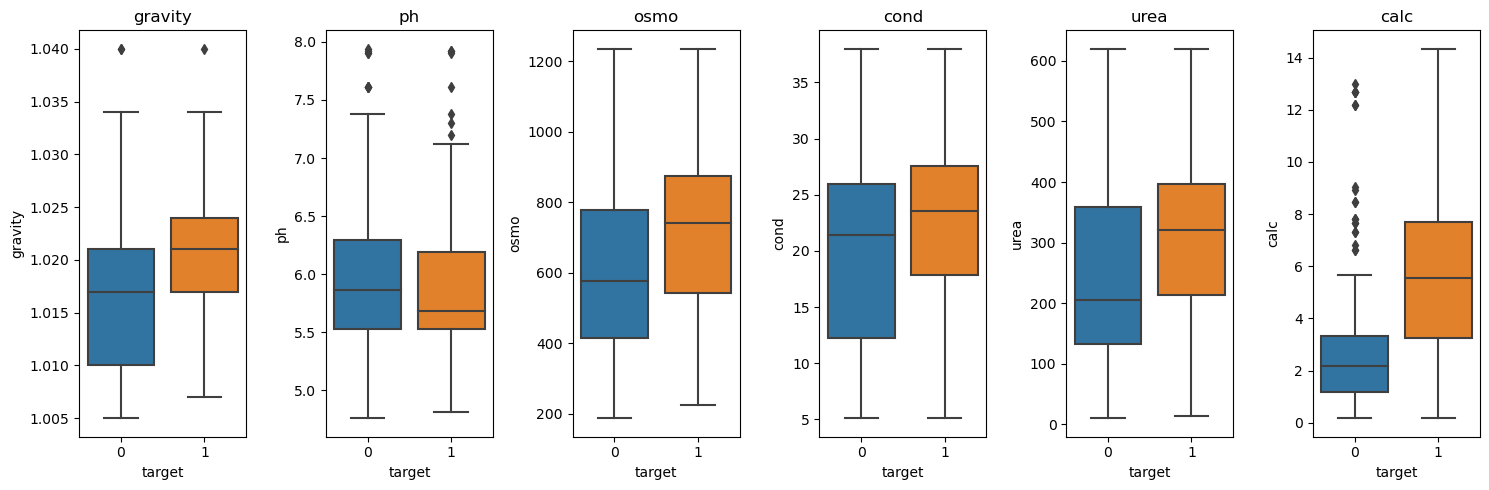

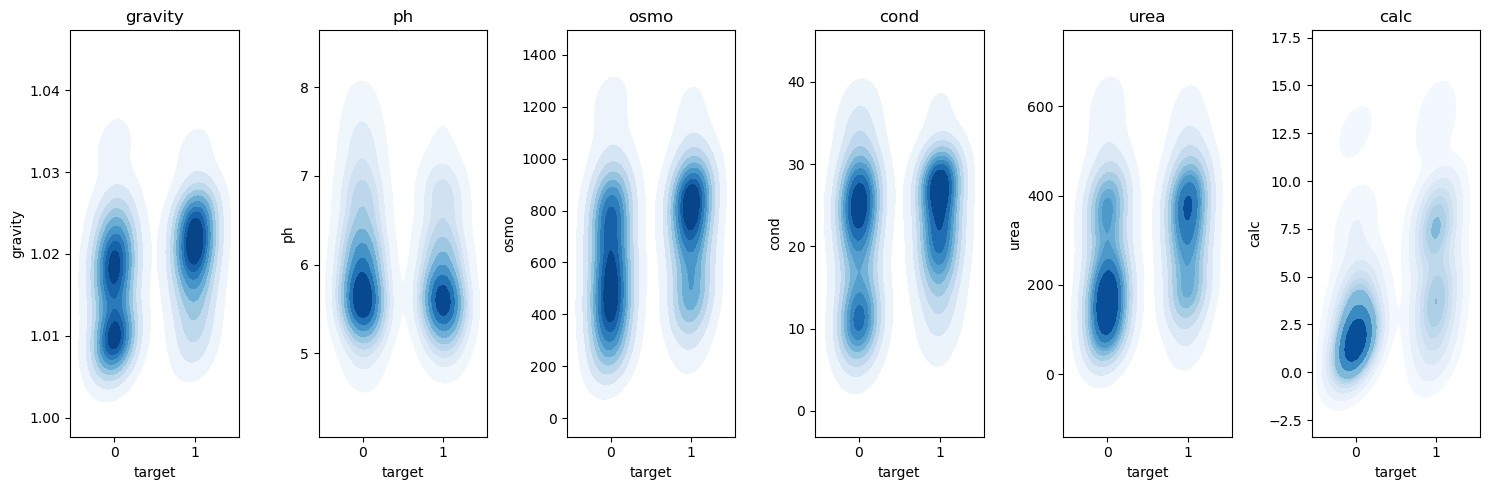

In [4]:
fig, axs = plot_features(train, 'box')
fig, axs = plot_features(train, 'kde')

### Original dataset

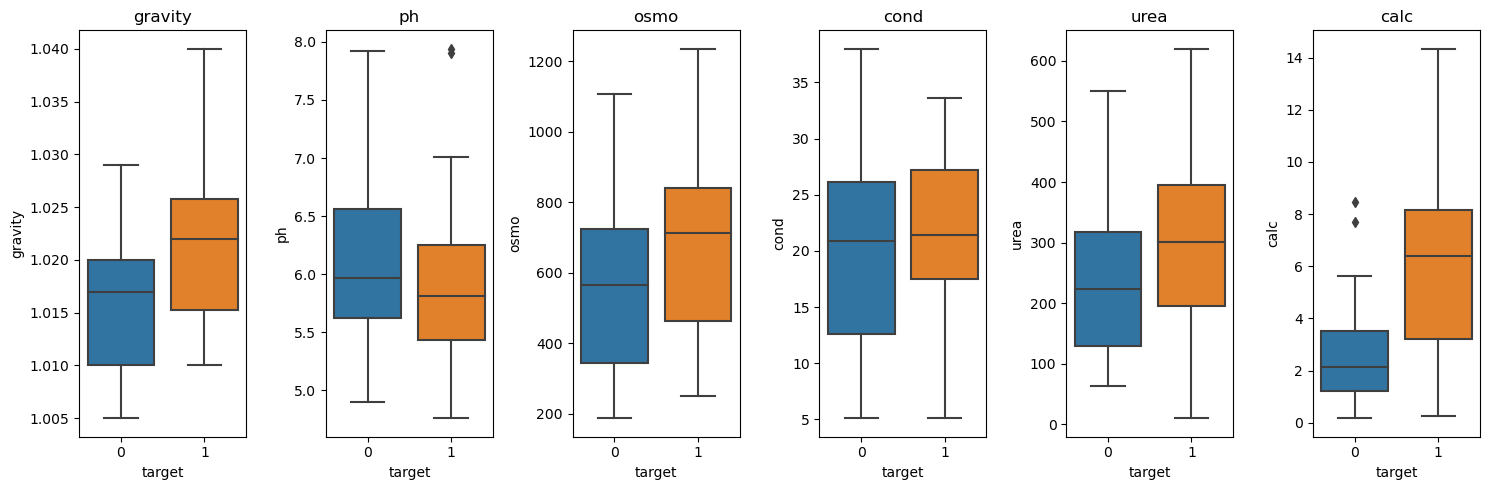

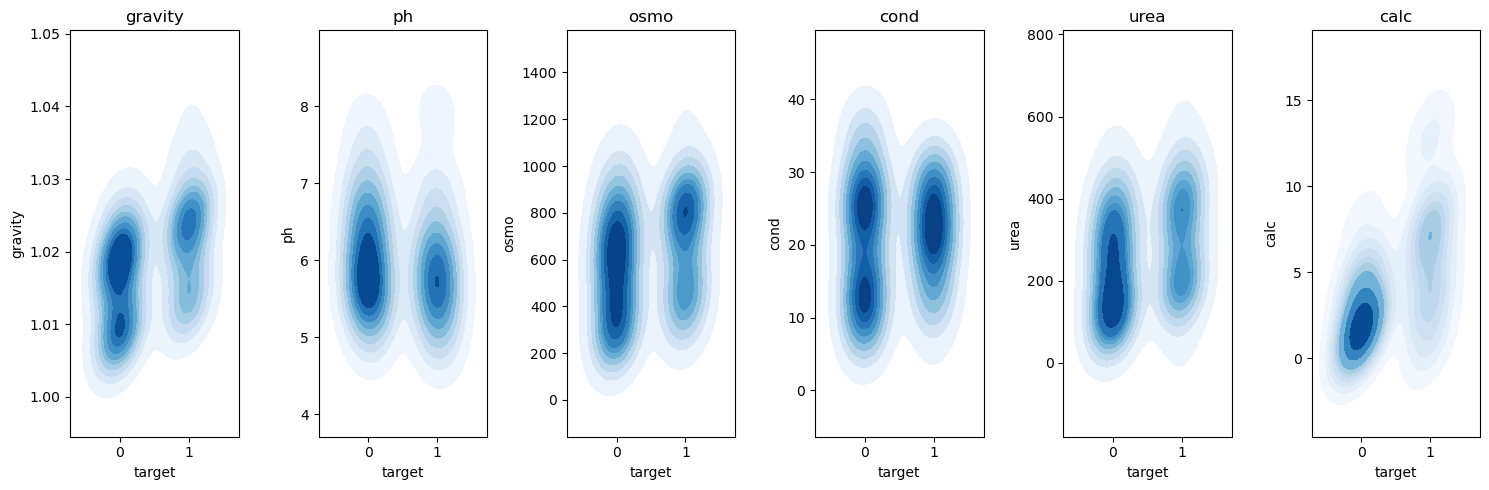

In [5]:
fig, axs = plot_features(original, 'box')
fig, axs = plot_features(original, 'kde')

### Train + original distribution with test dataset

In [6]:
# concat train and original 
train = pd.concat([train, original],axis=0)

# drop ID from train and test
drop_id = lambda n: n.drop(columns=['id'],inplace=True)
drop_id(train)
drop_id(test)

In [7]:
def compare_dist(train, test, features):
    fig, axes = plt.subplots(1, len(features), figsize=(15, 5))
    for i, feature in enumerate(features):
        sns.kdeplot(data=train, x=feature, color='blue', shade=True, ax=axes[i])
        sns.kdeplot(data=test, x=feature, color='red', shade=True, ax=axes[i])
        axes[i].set_title(feature.capitalize())
    fig.suptitle('Comparison of Features between Train and Test', fontsize=14)
    plt.tight_layout()
    plt.show()

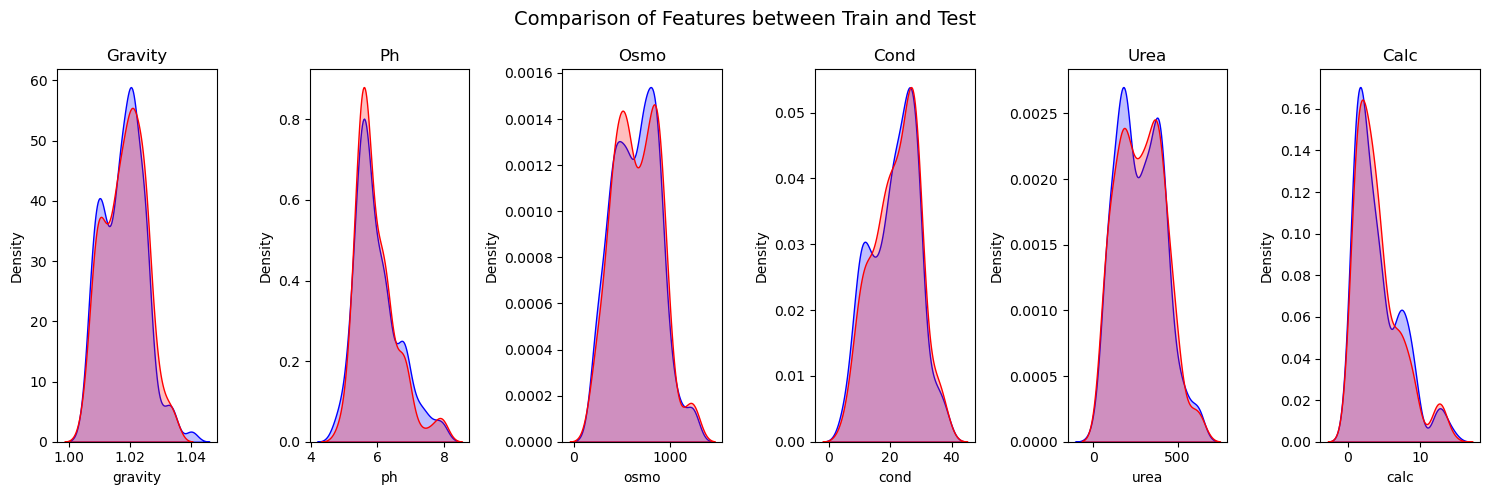

In [8]:
features = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
compare_dist(train, test, features)

In [9]:
def feature_engineering(train):    
    # train['hydration_status'] = np.where(train['gravity'] > 1.020, 0, 
    #                                      np.where(train['gravity'] >= 1.010, 1, 2))
    
    # train['ph_binary'] = np.where(train['ph'] < 5, 0, np.where(train['ph'] <= 7, 1, 2))
    
    # train['osmo_status'] = np.where((train['osmo'] >= 500) & (train['osmo'] <= 800), 1,
    #                      np.where(train['osmo'] < 500, 0, 2))
    
    # train['calc_status'] = np.where((train['calc'] >= 2) & (train['calc'] <= 6), 1,
    #                      np.where(train['calc'] < 2, 0, 2))
    
    train["sum"] = train['calc']+train['gravity']-8.20807805874e-3*train['cond']
    
    if 'target' in train.columns:
        train.drop(index=[55], inplace=True)
    
    return train


train = feature_engineering(train)
test = feature_engineering(test)  

In [10]:
# def cross_validate(data_variants):
#     pipeline_names = []
#     auc_scores = []
#     for name, features, pipeline in data_variants:
#         cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20,random_state=42)
#         auc = cross_val_score(pipeline, train[features], train['target'], scoring='roc_auc', cv=cv).mean()
#         pipeline_names.append(name)
#         auc_scores.append(auc)
#     return pipeline_names, auc_scores

def cross_validate(data_variants):
    pipeline_names = []
    train_aucs = []
    val_aucs = []
    for name, features, pipeline in data_variants:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)
        train_auc_scores = []
        val_auc_scores = []
        for train_index, val_index in cv.split(train[features], train['target']):
            X_train, y_train = train[features].iloc[train_index], train['target'].iloc[train_index]
            X_val, y_val = train[features].iloc[val_index], train['target'].iloc[val_index]

            pipeline.fit(X_train, y_train)

            train_pred = pipeline.predict_proba(X_train)[:, 1]
            val_pred = pipeline.predict_proba(X_val)[:, 1]

            train_auc = roc_auc_score(y_train, train_pred)
            val_auc = roc_auc_score(y_val, val_pred)

            train_auc_scores.append(train_auc)
            val_auc_scores.append(val_auc)

        pipeline_names.append(name)
        train_aucs.append(sum(train_auc_scores) / len(train_auc_scores))
        val_aucs.append(sum(val_auc_scores) / len(val_auc_scores))
        
        train_val_diff = train_aucs[-1] - val_aucs[-1]
        train_val_percent_diff = 100 * train_val_diff / val_aucs[-1]
        
        print("-"*50)
        print(f"Pipeline:                 {name}")
        print(f"Train AUC:                {train_aucs[-1]:.4f}")
        print(f"Validation AUC:           {val_aucs[-1]:.4f}")
        print(f"Train-Val AUC Difference: {train_val_diff:.4f} ({train_val_percent_diff:.2f}%)")
        print("-"*50)
        print()
        
    return pipeline_names, train_aucs, val_aucs

# KNN

- Parameters for KNN models.
- Best KNN models.

In [11]:
KNN_gravity_calc_params =  {'n_neighbors': 73, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'kd_tree'}
KNN_sum_calc_params     =  {'n_neighbors': 71, 'weights': 'uniform', 'metric': 'chebyshev', 'algorithm': 'auto'}
KNN_calc_params         =  {'n_neighbors': 70, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'ball_tree'}
KNN_sum_params          =  {'n_neighbors': 80, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'brute'}

In [12]:
knn_data_variants = [
    ('knn_gravity_calc', ['gravity', 'calc'], make_pipeline(FunctionTransformer(lambda X: X * np.array([[0.7780329719956114, 0.21875886146094936]])), KNeighborsClassifier(**KNN_gravity_calc_params))),
    ('knn_sum_calc', ['calc','sum'], make_pipeline(FunctionTransformer(lambda X: X * np.array([[0.7800605822206705, 0.3763433083744653]])), KNeighborsClassifier(**KNN_sum_calc_params))),
    ('knn_calc', ['calc'],  make_pipeline(MinMaxScaler(), KNeighborsClassifier(**KNN_calc_params))),
    ('knn_sum', ['sum'], make_pipeline(MinMaxScaler(), KNeighborsClassifier(**KNN_sum_params))),
]
 
knn_pipeline, knn_train_aucs, knn_val_aucs = cross_validate(knn_data_variants)

--------------------------------------------------
Pipeline:                 knn_gravity_calc
Train AUC:                0.8232
Validation AUC:           0.8227
Train-Val AUC Difference: 0.0005 (0.06%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 knn_sum_calc
Train AUC:                0.8225
Validation AUC:           0.8205
Train-Val AUC Difference: 0.0020 (0.24%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 knn_calc
Train AUC:                0.8229
Validation AUC:           0.8204
Train-Val AUC Difference: 0.0024 (0.29%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 knn_sum
Train AUC:                0.8209
Validation AUC:           0.8207
Train-Val AUC Difference: 0.0001 (0.02%)
--------------------------------------------------



### Hypertune KNN

In [13]:
def cross_validate_optuna(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 60, 90)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree','brute'])
    pipeline = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, algorithm=algorithm)

    # Inner cross-validation for model selection
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=inner_cv).mean()

    # Outer cross-validation for model evaluation
    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)
    nested_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=outer_cv).mean()
    
    return nested_auc

def objective(trial):
    auc = cross_validate_optuna(trial)
    return auc

# X = train[['sum']]
# y = train['target']

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print('Best hyperparameters: ', study.best_params)
# print('Best AUC score: ', study.best_value)

In [14]:
def objective(trial):
    factor_1 = trial.suggest_uniform('factor_1', 0, 1)
    factor_2 = trial.suggest_uniform('factor_2', 0, 1)
    pipeline = make_pipeline(FunctionTransformer(lambda X: X * np.array([[factor_1, factor_2]])), KNeighborsClassifier(**KNN_gravity_calc_params))

    # Inner cross-validation for model selection
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=inner_cv).mean()

    # Outer cross-validation for model evaluation
    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)
    nested_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=outer_cv).mean()
    
    return nested_auc

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print('Best hyperparameters: ', study.best_params)
# print('Best AUC score: ', study.best_value)

# SVC

In [15]:
svc_data_variants = [
    ('svc_gravity_calc', ['gravity', 'calc'], make_pipeline(FunctionTransformer(lambda X: X * np.array([[0.7780329719956114, 0.21875886146094936]])), 
                                                            SVC(C = 0.37419592566585536, gamma = "scale", probability=True, random_state = 42, kernel = "rbf"))),
    
    ('svc_sum_calc', ['sum', 'calc'], make_pipeline(FunctionTransformer(lambda X: X * np.array([[0.7800605822206705, 0.3763433083744653]])), 
                                                    SVC(C = 0.37419592566585536, gamma = "scale", probability=True, random_state = 42, kernel = "rbf"))),
    
    ('svc_calc', ['calc'], make_pipeline(MinMaxScaler(), 
                                         SVC(C = 0.37419592566585536, gamma = "scale", probability=True, random_state = 42, kernel = "rbf"))),
    
    ('svc_sum', ['sum'], make_pipeline(MinMaxScaler(), 
                                       SVC(C = 0.37419592566585536, gamma = "scale", probability=True, random_state = 42, kernel = "rbf"))),]

svc_pipeline, svc_train_aucs, svc_val_aucs = cross_validate(svc_data_variants)

--------------------------------------------------
Pipeline:                 svc_gravity_calc
Train AUC:                0.8236
Validation AUC:           0.8216
Train-Val AUC Difference: 0.0020 (0.25%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 svc_sum_calc
Train AUC:                0.8222
Validation AUC:           0.8209
Train-Val AUC Difference: 0.0013 (0.16%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 svc_calc
Train AUC:                0.8230
Validation AUC:           0.8218
Train-Val AUC Difference: 0.0013 (0.15%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 svc_sum
Train AUC:                0.8241
Validation AUC:           0.8223
Train-Val AUC Difference: 0.0018 (0.22%)
--------------------------------------------------



In [16]:
def cross_validate_optuna(trial):
    c = trial.suggest_float('C', 0.2, 0.6)
    pipeline = SVC(C = c, gamma = "scale", probability=True, random_state = 42, kernel = "rbf")

    # Inner cross-validation for model selection
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=inner_cv).mean()

    # Outer cross-validation for model evaluation
    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)
    nested_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=outer_cv).mean()
    
    return nested_auc

def objective(trial):
    auc = cross_validate_optuna(trial)
    return auc

# X = train[['gravity', 'calc']]
# y = train['target']

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print('Best hyperparameters: ', study.best_params)
# print('Best AUC score: ', study.best_value)

# VotingClassifier

In [17]:
VC_classifiers = {
    # First VC model
    'VC_gravity_calc':
    (('knn_gravity_calc', knn_data_variants[0][2]),
     ('svc_gravity_calc', svc_data_variants[0][2])),
    
    # Second VC model
    'VC_sum_calc':
    (('knn_sum_calc', knn_data_variants[1][2]),
     ('svc_sum_calc', svc_data_variants[1][2])),
    
    # Third VC model
    'VC_calc':
    (('knn_calc', knn_data_variants[2][2]),
     ('svc_calc', svc_data_variants[2][2])),
    
    # Fourth VC model
    'VC_sum':
    (('knn_sum', knn_data_variants[3][2]),
     ('svc_sum', svc_data_variants[3][2]))
}

In [18]:
voting_data_variants = [
    ('VC_gravity_calc', ['gravity', 'calc'], make_pipeline(VotingClassifier(VC_classifiers['VC_gravity_calc'], voting='soft', weights=[0.08630843439096336,0.916094778960392]))),
    ('VC_sum_calc', ['sum', 'calc'], make_pipeline(VotingClassifier(VC_classifiers['VC_sum_calc'], voting='soft', weights=[0.009883139788447907,0.5051757706982735]))),
    ('VC_calc', ['calc'],make_pipeline(VotingClassifier(VC_classifiers['VC_calc'], voting='soft', weights=[0.07211447101933181,0.8967184211897058]))),
    ('VC_sum', ['sum'], make_pipeline(VotingClassifier(VC_classifiers['VC_sum'], voting='soft', weights=[0.020470129817348748,0.7464487416760202])))
]

VC_pipeline, VC_train_aucs, VC_val_aucs = cross_validate(voting_data_variants)

--------------------------------------------------
Pipeline:                 VC_gravity_calc
Train AUC:                0.8270
Validation AUC:           0.8245
Train-Val AUC Difference: 0.0025 (0.31%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 VC_sum_calc
Train AUC:                0.8235
Validation AUC:           0.8218
Train-Val AUC Difference: 0.0017 (0.21%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 VC_calc
Train AUC:                0.8262
Validation AUC:           0.8240
Train-Val AUC Difference: 0.0022 (0.27%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 VC_sum
Train AUC:                0.8261
Validation AUC:           0.8246
Train-Val AUC Difference: 0.0015 (0.18%)
--------------------------------------------------



### Tune VC weights

In [19]:
def objective(trial):
    w1 = trial.suggest_uniform('w1', 0, 1)
    w2 = trial.suggest_uniform('w2', 0, 1)
    pipeline = make_pipeline(VotingClassifier(VC_classifiers['VC_sum'], voting='soft', weights=[w1,w2]))

    # Inner cross-validation for model selection
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=inner_cv).mean()

    # Outer cross-validation for model evaluation
    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)
    nested_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=outer_cv).mean()
    
    return nested_auc

# X = train[['sum']]
# y = train['target']

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# print('Best hyperparameters: ', study.best_params)
# print('Best AUC score: ', study.best_value)

# StackingClassifier

In [20]:
SC_classifiers = {
    # First SC model
    'SC_gravity_calc':
    [('knn_gravity_calc', knn_data_variants[0][2]),
     ('svc_gravity_calc', svc_data_variants[0][2]),
     ('VC_gravity_calc', voting_data_variants[0][2]),
    ],
    
    # Second SC model
    'SC_sum_calc':
    [('knn_sum_calc', knn_data_variants[1][2]),
     ('svc_sum_calc', svc_data_variants[1][2]),
     ('VC_sum_calc', voting_data_variants[1][2])
    ],
    
    # Third SC model
    'SC_calc':
    [('knn_calc', knn_data_variants[2][2]),
     ('svc_calc', svc_data_variants[2][2]),
     ('VC_calc', voting_data_variants[2][2]),
    ],
    
    # Fourth SC model
    'SC_sum':
    [('knn_sum', knn_data_variants[3][2]),
     ('svc_sum', svc_data_variants[3][2]),
     ('VC_sum', voting_data_variants[3][2]),
    ]
}

In [21]:
stacking_data_variants = [
    ('SC_gravity_calc', ['gravity', 'calc'], make_pipeline(StackingClassifier(estimators=SC_classifiers['SC_gravity_calc'], final_estimator=LogisticRegression(C = 0.3, max_iter = 10000, random_state=42)))),
    ('SC_sum_calc', ['sum', 'calc'], make_pipeline(StackingClassifier(estimators=SC_classifiers['SC_sum_calc'], final_estimator=LogisticRegression(C = 0.3, max_iter = 10000, random_state=42)))),
    ('SC_calc', ['calc'], make_pipeline(StackingClassifier(estimators=SC_classifiers['SC_calc'], final_estimator=LogisticRegression(C = 0.3, max_iter = 10000, random_state=42)))),
    ('SC_sum', ['sum'], make_pipeline(StackingClassifier(estimators=SC_classifiers['SC_sum'], final_estimator=LogisticRegression(C = 0.3, max_iter = 10000, random_state=42))))
]

SC_pipeline, SC_train_aucs, SC_val_aucs = cross_validate(stacking_data_variants)

--------------------------------------------------
Pipeline:                 SC_gravity_calc
Train AUC:                0.8243
Validation AUC:           0.8221
Train-Val AUC Difference: 0.0022 (0.26%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 SC_sum_calc
Train AUC:                0.8205
Validation AUC:           0.8179
Train-Val AUC Difference: 0.0025 (0.31%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 SC_calc
Train AUC:                0.8242
Validation AUC:           0.8208
Train-Val AUC Difference: 0.0033 (0.40%)
--------------------------------------------------

--------------------------------------------------
Pipeline:                 SC_sum
Train AUC:                0.8237
Validation AUC:           0.8221
Train-Val AUC Difference: 0.0015 (0.19%)
--------------------------------------------------



In [22]:
scores = {}

models = [('KNN_gravity_calc', knn_train_aucs[0], knn_val_aucs[0]),
          ('KNN_sum_calc', knn_train_aucs[1], knn_val_aucs[1]),
          ('KNN_calc', knn_train_aucs[2], knn_val_aucs[2]),
          ('KNN_sum', knn_train_aucs[3], knn_val_aucs[3]),
          ('SVC_gravity_calc', svc_train_aucs[0], svc_val_aucs[0]),
          ('SVC_sum_calc', svc_train_aucs[1], svc_val_aucs[1]),
          ('SVC_calc', svc_train_aucs[2], svc_val_aucs[2]),
          ('SVC_sum', svc_train_aucs[3], svc_val_aucs[3]),
          ('VC_gravity_calc', VC_train_aucs[0], VC_val_aucs[0]),
          ('VC_sum_calc', VC_train_aucs[1], VC_val_aucs[1]),
          ('VC_calc', VC_train_aucs[2], VC_val_aucs[2]),
          ('VC_sum', VC_train_aucs[3], VC_val_aucs[3]),
          ('SC_gravity_calc', SC_train_aucs[0], SC_val_aucs[0]),
          ('SC_sum_calc', SC_train_aucs[1], SC_val_aucs[1]),
          ('SC_calc', SC_train_aucs[2], SC_val_aucs[2]),
          ('SC_sum', SC_train_aucs[3], SC_val_aucs[3]),
         ]

for model in models:
    model_name = model[0]
    train_auc = round(model[1], 4)
    val_auc = round(model[2], 4)
    overfitting = round((train_auc - val_auc) / train_auc * 100, 4)
    scores[model_name] = {'train_auc': train_auc, 'val_auc': val_auc, 'overfitting (%)': overfitting}

In [23]:
scores = pd.DataFrame(scores)
scores = scores.T.reset_index().rename(columns={'index': 'model'})

In [24]:
scores.sort_values('val_auc', ascending=False).style.background_gradient(cmap='Blues')

,model,train_auc,val_auc,overfitting (%)
11,VC_sum,0.826100,0.824600,0.181600
8,VC_gravity_calc,0.827000,0.824500,0.302300
10,VC_calc,0.826200,0.824000,0.266300
0,KNN_gravity_calc,0.823200,0.822700,0.060700
7,SVC_sum,0.824100,0.822300,0.218400
12,SC_gravity_calc,0.824300,0.822100,0.266900
15,SC_sum,0.823700,0.822100,0.194200
6,SVC_calc,0.823000,0.821800,0.145800
9,VC_sum_calc,0.823500,0.821800,0.206400
4,SVC_gravity_calc,0.823600,0.821600,0.242800


# Submission

In [25]:
final_model = make_pipeline(VotingClassifier(VC_classifiers['VC_sum'], voting='soft', weights=[0.020470129817348748,0.7464487416760202]))
final_model.fit(train[['sum']], train['target'])
predictions = final_model.predict_proba(test[['sum']])[:, 1]

In [26]:
sub = pd.read_csv("/kaggle/input/playground-series-s3e12/sample_submission.csv")
sub.target = predictions
sub.to_csv('submission.csv',index=False)